<h1>Overview of the Problem</h1>

In [2]:
#Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [1]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Read file, do a little formatting and drop an column.
data = pd.read_csv('/content/drive/MyDrive/covid_parsed5_srs2.csv', index_col=0)
data.reset_index(inplace = True)
data.drop('res_state',axis = 1, inplace = True)

In [4]:
#Convert all Missing values to one string
data = data.replace('Unknown', 'N/A')
data = data.replace('Missing', 'N/A')
data = data.replace(np.nan, 'N/A')

In [5]:
#Create Dummy variables for race column
for i in data['race'].unique():  
  data[''.join(['race_',str(i)])] = pd.get_dummies(data['race'])[i]
data = data.drop('race',axis=1)
data = data.replace(0,'No')
data = data.replace(1,'Yes')

In [6]:
#Data cleaning, replaces string values to integer for easier regression
data_num = data_num = data
data_num = data_num.replace('No',0)
data_num = data_num.replace('Yes',1)
data_num = data_num.replace('Symptomatic',1)
data_num = data_num.replace('Asymptomatic',0)
data_num = data_num.replace('Male',1)
data_num = data_num.replace('Female',0)
data_num = data_num.replace('Hispanic/Latino',1)
data_num = data_num.replace('Non-Hispanic/Latino',0)
data_num = data_num.replace(['18 to 49 years', '50 to 64 years', '0 - 17 years', '65+ years'],range(0,4))
data_num = data_num.replace('N/A',-1)

In [7]:
#This dataframe is used for plotting
data_plt = data[data.death_yn == 'Yes']


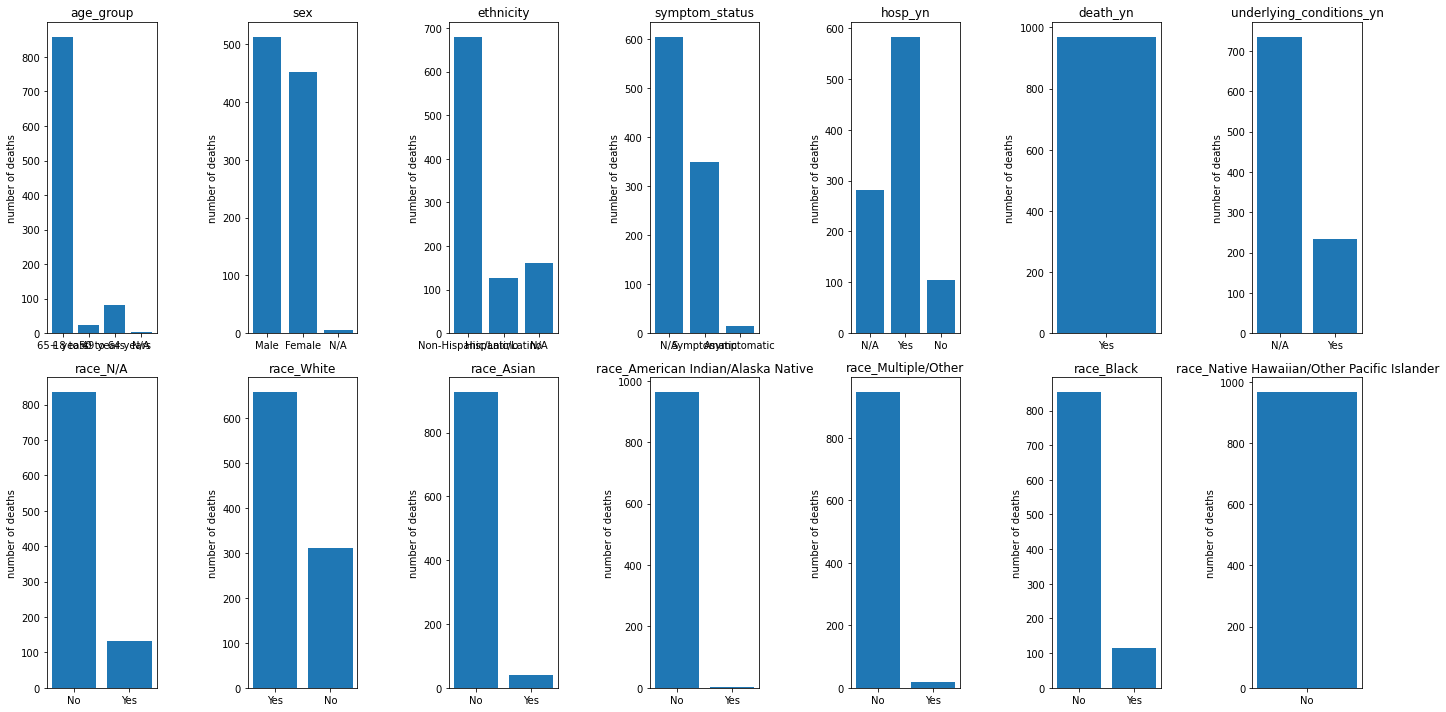

In [8]:
#Plots the deaths with respect to the categorical variables
cols = data_plt.columns

fig, axes = plt.subplots(2, 7, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    x = data_plt[cols[i]].unique()
    y = [list(data_plt[cols[i]]).count(v) for v in x]
    ax.bar(x,y)
    ax.set_ylabel('number of deaths')
    ax.set_title(str(cols[i]))


plt.tight_layout()
plt.show()

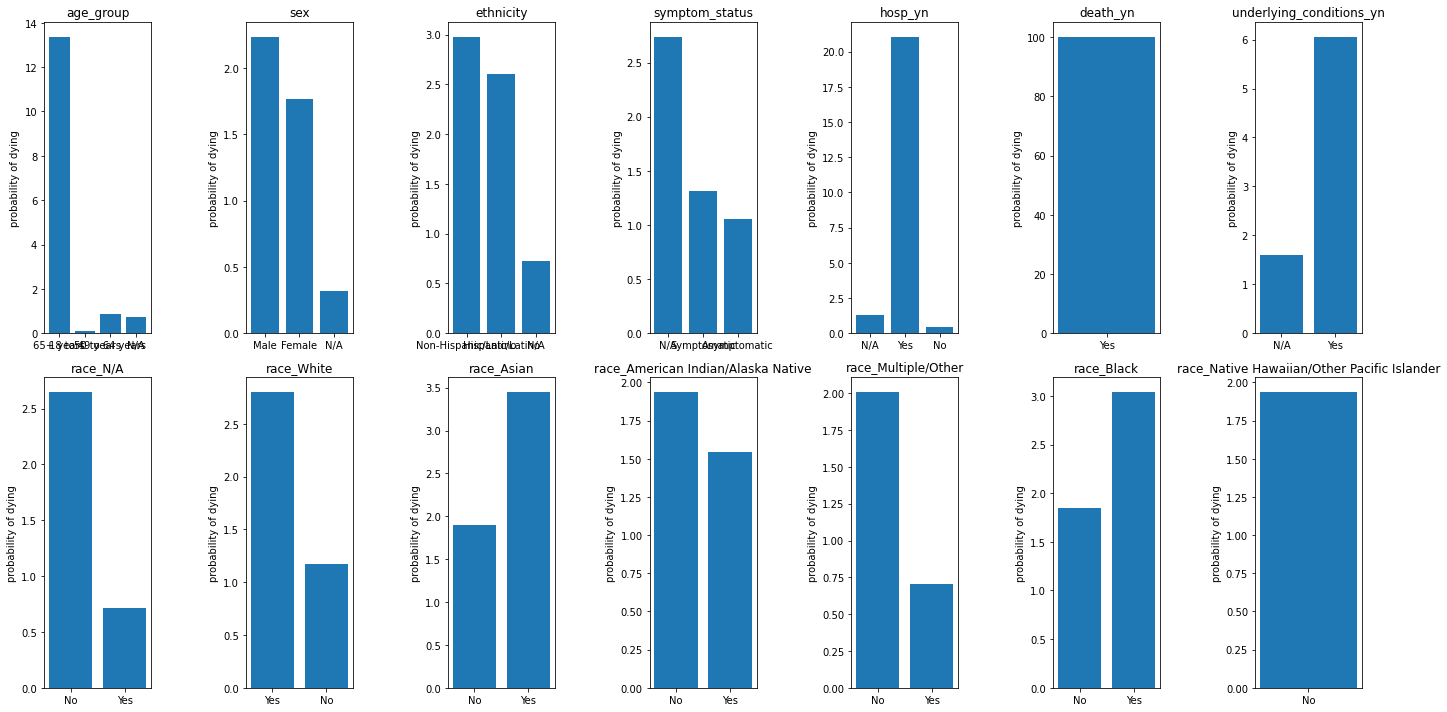

In [9]:
#Very similar graph to above, except this time we're plotting the probability to try to remove any imbalance in the dataset.
fig, axes = plt.subplots(2, 7, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    x = data_plt[cols[i]].unique()
    y = [(list(data_plt[cols[i]]).count(v))/(list(data[cols[i]]).count(v))*100 for v in x]
    ax.bar(x,y)
    ax.set_ylabel('probability of dying') #given the patient is symptomatic
    ax.set_title(str(cols[i]))


plt.tight_layout()
plt.show()

In [10]:
#Creating the X set and Y set.
inp_feats = ['age_group', 'sex', 'ethnicity', 'symptom_status', 'hosp_yn',
       'underlying_conditions_yn', 'race_N/A', 'race_White',
       'race_Asian', 'race_American Indian/Alaska Native',
       'race_Multiple/Other', 'race_Black',
       'race_Native Hawaiian/Other Pacific Islander']
X = data_num[inp_feats]

y = data_num.death_yn

In [11]:
#Train test split, splits the data into training and testing data sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, 
                                         random_state = 42)

In [ ]:
#Perform grid search to find the best random forest parameters
rf_model = RandomForestClassifier()

#Setup of parameters and gridsearch
leaf = np.arange(1,10)
depths = np.arange(1,5)
param = {'min_samples_leaf': leaf,
         'max_depth': depths}

#Set up grid search
grid_search = GridSearchCV(estimator = rf_model, 
                           param_grid = param ,
                           cv = 3, 
                           scoring = 'neg_mean_squared_error', 
                           return_train_score=True )

#Grid search
grid_search.fit(X_train,y_train)

#Prints the best parameters
grid_search.best_params_

#Note, takes a bit long to run. Probabably should skip running this.

{'max_depth': 4, 'min_samples_leaf': 5}

In [12]:
#Fits the training data with the random forest model with optimized parameters found with gridsearch
rf_model = RandomForestClassifier(max_depth = 4, min_samples_leaf =  5)
rf_model = rf_model.fit(X_train, y_train)

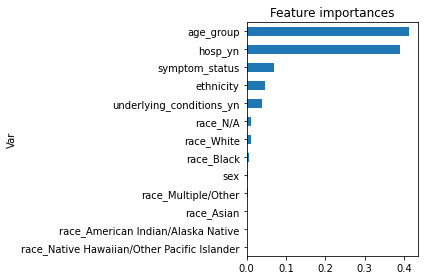

In [13]:
#Plotting feature importances
importances = rf_model.feature_importances_
forest_importances = pd.Series(importances, index=inp_feats).sort_values()
fig, ax = plt.subplots()
forest_importances.plot.barh()
ax.set_title("Feature importances")
ax.set_ylabel("Var")
fig.tight_layout()

In [14]:
#Gets the result from using model on testing data
pred_prob = rf_model.predict_proba(X_test)
probs = pred_prob[:,1]
pred = np.where(probs > probs.mean(), 1,0)

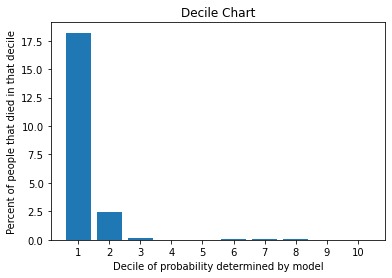

In [15]:
#Decile Chart
temp = pd.DataFrame(pred_prob)
temp['Decile_rank'] = pd.qcut(temp[0], 10,
                            labels = False)
temp['death_yn'] = y_test.reset_index().death_yn

x_decile = [1,2,3,4,5,6,7,8,9,10]
y_decile = [list(temp[temp['Decile_rank'] == i]['death_yn']).count(1)/(1500)*100 for i in range(0,10)]


plt.bar(x_decile,y_decile)
plt.xticks(x_decile)
plt.xlabel('Decile of probability determined by model')
plt.ylabel('Percent of people that died in that decile')
plt.title('Decile Chart')
plt.show()

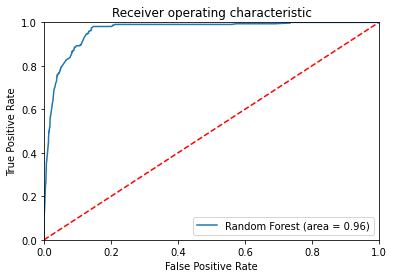

In [16]:
#ROC curve analysis
#Import the packages. 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, pred_prob[:,1])


#Gives you the points for the roc-curve 
fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:,1])


plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [17]:
#Metrics used to evaluate the model
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, f1_score
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92     14684
           1       0.13      0.96      0.23       316

    accuracy                           0.86     15000
   macro avg       0.56      0.91      0.58     15000
weighted avg       0.98      0.86      0.91     15000



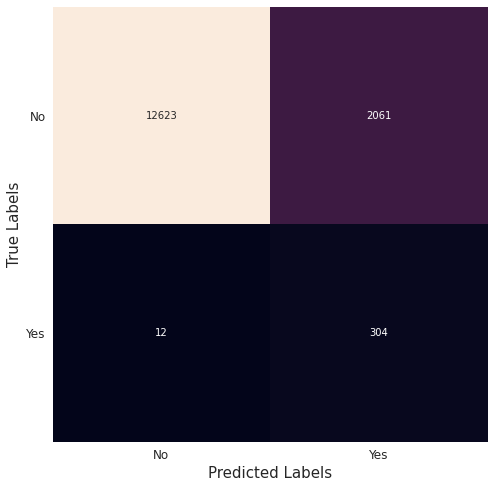

In [18]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_style('white')
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(12, 8))
ax = sns.heatmap(cm, square=True, annot=True, cbar=False, fmt='g')
ax.xaxis.set_ticklabels(['No','Yes'], fontsize = 12)
ax.yaxis.set_ticklabels(['No','Yes'], fontsize = 12, rotation=0)
ax.set_xlabel('Predicted Labels',fontsize = 15)
ax.set_ylabel('True Labels',fontsize = 15)
plt.show()

<h1>Results:</h1>

The random forest model was optimized with a gridsearch, and the decision threshold was chosen to optimize the recall and precision. The recall was found to be 0.96, while the precision is a low 0.13. In real life the application of the model would be useful for more effecient allocation of resources, so more lives lost due to covid could be saved.